# Learn by example Expectation Maximization

https://www.kaggle.com/code/charel/learn-by-example-expectation-maximization/notebook

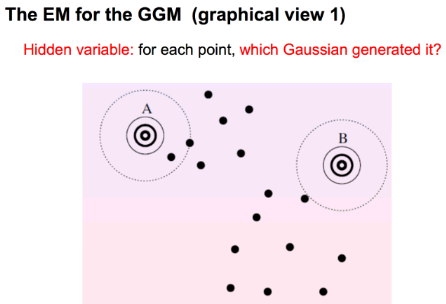

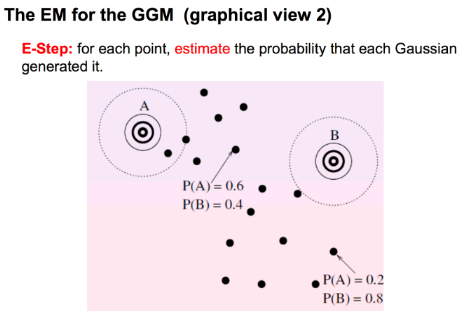

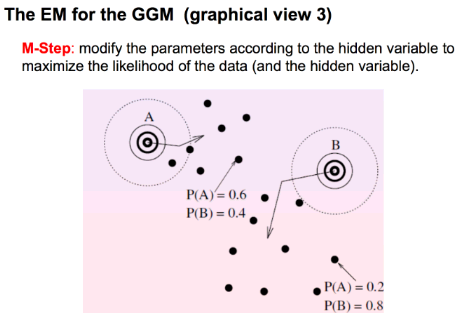

In [310]:
# import libraries

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

#for matrix math
import numpy as np

#for normalization + probability density function computation
from scipy import stats

#for data preprocessing
import pandas as pd

from math import sqrt, log, exp, pi
from random import uniform
print("import done")

import done


(1500,)
Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0


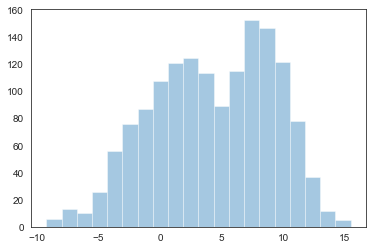

In [311]:
# Generate the data yourself Select  μ1,σ1  and  μ2,σ2  to generate the data
random_seed=202211
np.random.seed(random_seed)

Mean1 = 2.0  # Input parameter, mean of the first normal probability distribution
Standard_dev1 = 4.0 # standard deviation of the first normal probability distribution
Mean2 = 9.0 # Input parameter, mean of the second normal  probability distribution
Standard_dev2 = 2.0 # standard deviation of the second normal probability distribution

# generate data
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)
print(data.shape)

# For data visiualisation calculate left and right of the graph
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # to plot the data

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
sns.distplot(data, bins=20, kde=False);

In [312]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
print("done")

done


Best single Gaussian: μ = 4.3, σ = 4.8


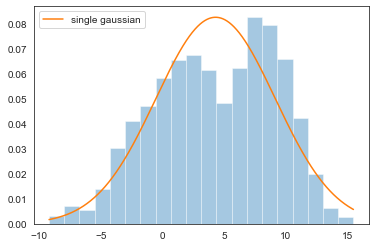

In [313]:
# A single Gaussion will not fit the data well
# Calculating the mean and standard deviation of the dataset shows it does not fit well

#gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

#fit a single gaussian curve with the mean best_single.mu and std est_single.sigma to the data
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)

sns.distplot(data, bins=20, kde=False, norm_hist=True);
plt.plot(x, g_single, label='single gaussian');
plt.legend();

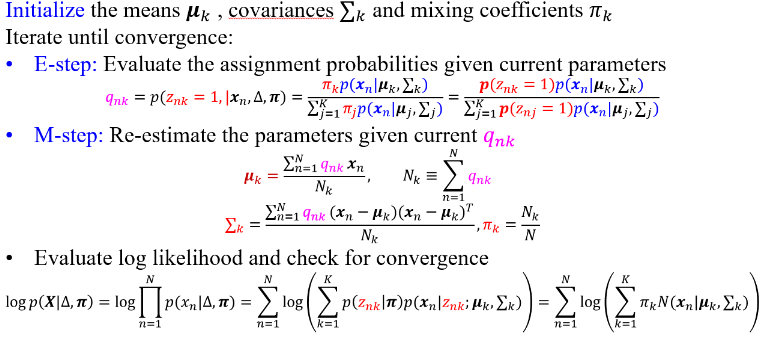

In [314]:
class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1, mix=.5):
        self.data = data
        # Algorithm would be numerical enhanced by normalizing the data first, 
        # next do all the EM steps and do the de-normalising at the end
        
        # init with multiple gaussians
        # uniform(x,y): 在[x,y]之間隨機產生一個數字，產生的pdf是1/(y-x)
        
        self.one = Gaussian(uniform(mu_min, mu_max), uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), uniform(sigma_min, sigma_max))
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(den) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators    
        (left, rigt) = zip(*weights) # *weights 即是所有的 (wp1, wp2)
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        
        self.one.mu = sum(w * d  for (w, d) in zip(left, self.data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, self.data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, self.data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, self.data)) / two_den)
        # compute new mix
        self.mix = one_den / len(self.data)
            
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
print("done")

done


In [315]:
# See the algorithm in action
n_iterations = 20
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
            
    # Catch division errors from bad starts, and just throw them out...    
    except (ZeroDivisionError, ValueError, RuntimeWarning): 
        print("one less")
        pass

 1 Mixture: Gaussian(0.666758, 3.23446), Gaussian(8.53351, 2.2935), mix=0.54)
 1 Mixture: Gaussian(0.739111, 3.32807), Gaussian(8.50476, 2.32117), mix=0.543)
 1 Mixture: Gaussian(0.7943, 3.37826), Gaussian(8.5031, 2.33677), mix=0.547)
 1 Mixture: Gaussian(0.837075, 3.41198), Gaussian(8.51008, 2.34132), mix=0.55)
 1 Mixture: Gaussian(0.87237, 3.43679), Gaussian(8.52134, 2.33978), mix=0.553)
 1 Mixture: Gaussian(0.902916, 3.45632), Gaussian(8.53472, 2.33499), mix=0.556)
 1 Mixture: Gaussian(0.930254, 3.47259), Gaussian(8.54901, 2.32851), mix=0.559)
 1 Mixture: Gaussian(0.955283, 3.48673), Gaussian(8.56351, 2.32124), mix=0.562)
 1 Mixture: Gaussian(0.978545, 3.49944), Gaussian(8.57781, 2.3137), mix=0.564)
 1 Mixture: Gaussian(1.00038, 3.51111), Gaussian(8.59168, 2.3062), mix=0.567)
 1 Mixture: Gaussian(1.021, 3.52199), Gaussian(8.605, 2.29888), mix=0.569)
 1 Mixture: Gaussian(1.04054, 3.53225), Gaussian(8.6177, 2.29186), mix=0.571)
 1 Mixture: Gaussian(1.05912, 3.54197), Gaussian(8.62977,

Computing best model with random restarts...

Best Gaussian Mixture : μ = 1.4, σ = 3.7 with μ = 8.9, σ = 2.2
Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0
Gaussian 1: μ = 1.4, σ = 3.7, weight = 0.62
Gaussian 2: μ = 8.9, σ = 2.2, weight = 0.38


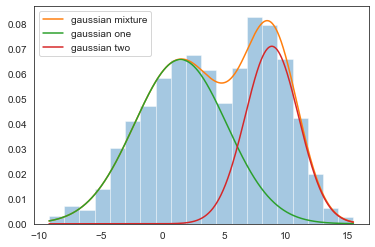

In [316]:
# Find best Mixture Gaussian model
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("1", best_mix.one.mu, best_mix.one.sigma, best_mix.mix))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("2", best_mix.two.mu, best_mix.two.sigma, (1-best_mix.mix)))
#Show mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True);
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
plt.legend();

# sklearn GaussianMixture

Or we could make use of a library that already has the functionality implemented. 
The sklearn GaussianMixture object implements the expectation-maximization (EM) algorithm 
for fitting mixture-of-Gaussian models. 
A GaussianMixture.fit method is provided that learns a Gaussian Mixture Model from train data. 
Now you can try yourself with n-Gaussians or m-dimensions.

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0
Gaussian 1: μ = 1.4, σ = 3.7, weight = 0.61
Gaussian 2: μ = 8.8, σ = 2.2, weight = 0.39


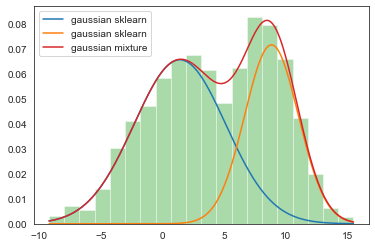

In [317]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2, tol=0.000001)

# Parameters: array-like, shape (n_samples, n_features), 1 dimension dataset so 1 feature
gmm.fit(np.expand_dims(data, 1)) 
Gaussian_nr = 1
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format(Gaussian_nr, mu, sd, p))
    g_s = stats.norm(mu, sd).pdf(x) * p
    plt.plot(x, g_s, label='gaussian sklearn');
    Gaussian_nr += 1
sns.distplot(data, bins=20, kde=False, norm_hist=True)

#gmm gives log probability, hence the exp() function
gmm_sum = np.exp([gmm.score_samples(e.reshape(-1, 1)) for e in x]) 
plt.plot(x, gmm_sum, label='gaussian mixture');
plt.legend();

In [318]:
# The followings are tests

http://kaiching.org/pydoing/py/python-yield.html

關鍵字 (keyword) yield 用在函數中對呼叫方產生數值，這是說函數 (function) 若使用 yield 產生數值的話，
函數會回傳一個產生器 (generator) 物件 (object) ，可由 __next__() 方法 (method) 或內建函數 
(built-in function) next() 依序取得 yield 產生的數值，注意 __next__() 方法前後被兩條底線包圍。
這樣的執行方式，就好像呼叫函數後，函數並不會立即直接結束，而是與呼叫方同時執行的。

先來看個簡單的例子，函數 yield5() 只有簡單利用關鍵字 yield 產生整數 5 ，變數 (variable) a 會取得 yield5() 回傳的產生器物件，然後利用內建函數 next() 先取得變數 a 產生的第一個數值，就是整數 5 ，再用 next() 一次，結果發生 StopIteration 的錯誤，因為變數 a 中已經沒有數值可以產生了

In [26]:
def yield5():
    yield 5

a = yield5()
print(next(a))
print(next(a))

5


StopIteration: 

In [134]:
def new_range(n):
    i = 0
    while i < n:
        yield i
        i += 1

b = new_range(10)

In [135]:
print(next(b))

0


In [136]:
print(next(b))

1


In [137]:
print(next(b))

2


用 for 迴圈 (loop) 可以印出 new_range() 產生的所有整數，例如

In [263]:
def new_range(n):
    i = 0
    while i < n:
        yield i
        i += 3

for i in new_range(10):
    print(i)

0
3
6
9


關鍵字 return 是在函數中回傳數值， return 跟 yield 的作用完全不同， return 後接的回傳值就是給呼叫方的物件，回傳值 (return value) 是什麼型態，呼叫方就得到什麼型態的物件，例如這裡定義了 fib() 函數，這是用來計算費氏數列的函數，結果回傳串列 (list) ，費氏數列則儲存在串列之中。

In [28]:
def fib(n):
    L = []
    i, a, b = 0, 0, 1
    while i < n:
        L.append(b)
        a, b = b, a + b
        i += 1
    
    return L

print(fib(10))

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55]


那函數用 return 跟 yield 有什麼不同呢？這裡的 fib2() 函數用 yield 產生費氏數列，相同參數得到的結果跟 fib() 一樣，差別是 fib2() 回傳的是產生器物件，而非串列，利用產生器物件的好處是節省記憶體空間，並且提升程式執行的效率，這優點在資料量極少的情況下看不出來，可是一旦資料量暴增，例如串列中需要儲存數十到數百萬筆資料的時候，相對產生器物件需要的記憶體空間就相當少，所以當資料是依序計算取得的話，利用產生器物件就比較適合

In [30]:
def fib2(n):
    i, a, b = 0, 0, 1
    while True:
        if n <= 0 or i == n:
            break
        a, b = b, a + b
        yield a
        i += 1

d = fib2(10)

print(d)

for i in d:
    print(i)

<generator object fib2 at 0x000002B47CB0B820>
1
1
2
3
5
8
13
21
34
55


https://chriskang028.medium.com/python-%E8%A3%A1%E7%9A%84-yield-%E8%AE%93%E4%BD%A0%E7%B0%A1%E5%96%AE-%E5%BF%AB%E9%80%9F%E7%9E%AD%E8%A7%A3-yield-%E7%9A%84%E6%A6%82%E5%BF%B5-f660521f3aa7

In [261]:
def foo():
    print("start...")
    while True:
        throw = yield 10
        print("throw is:",throw)
g = foo()

print(next(g))
print("*"*20)
print(next(g))
print("*"*30)
print(next(g))

start...
10
********************
throw is: None
10
******************************
throw is: None
10


1.程式開始執行後，因為函式 foo 裡有 yield，因此程式並不會直接運行，而是轉換成生成器（Generator）。

2.直到遇到 next() 函式（亦即使用到 while 或是 for 迴圈等），程式就會開始執行，因此開始丟出 start…。

3.到了 while 迴圈後，遇到了 yield 後面的 10，此時 yield 把 10 丟出去，因此印出了 10。

4.這時關鍵來了，丟完 10 之後 yield 就變成不可用（因為在該遞迴回合時只能被使用一次），且函式被凍結在 yield 丟出 10 這一行。

5.再來 print 印出一排的 ＊。

6.接下來再遇到下一次的迴圈，此時程式從上次凍結的 yield 這裡，繼續往下一行執行。

7.但此時 yield 已經把 10 丟出去了，因此左邊是沒有值的。造成此時的 throw 會沒有賦值，因此會丟出 None。

8.再進行下一輪的 while 迴圈，此時又遇到 yield 一次，因此又把 10 再丟出去一次，此時程式又停在這個地方。

In [151]:
# 直接在迴圈使用yield會出現錯誤，必須在一個function內使用，因為用yield會產生一個物件
for d in range(10):
    a=d+1
    yield a

SyntaxError: 'yield' outside function (<ipython-input-151-703393fc7b82>, line 3)

In [251]:
# This is the first trial
def test1():
    for d in range(5):
        yield (d, d+1)  

q=test1()

for i in q:
    print(i)

(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 5)


In [266]:
def test1():
    for d in range(5):
        return (d, d+1) 
    
q=test1()

print(q)

for i in q:
    print(i)

(0, 1)
0
1


In [267]:
# This is the second trial
def test1():
    for d in range(5):
        print('test1, d=',d)
        return (d, d+2)  
    
def test2(m):
    print('test2=',test2)
    #print(*m)
    (x, y)=zip(*m)
    print('x=',x)
    print('y=',y)
    
def it():
    for i in range(1, 2):
        print('i=',i)
        test2(test1())
        
for _ in range(1):
    it()

i= 1
test1, d= 0
test2= <function test2 at 0x000002B47CA444C0>


TypeError: 'int' object is not iterable

In [282]:
# This is the third trial
def test1():
    for d in range(5):
        print('test1', d, d+2)
        yield (d, d+2)  
    
def test2(m):
    print('Performing test2')
    print('m is',m)
    (x, y)=zip(*m) # 這裡是關鍵，因為 m 是generator物件，且 *m is iterable，因此會完成在 test1 中的迭代
    print('x=',x)
    print('y=',y)
    
def it():
    for i in range(1, 3):
        print('i=',i)
        test2(test1())
        
    test1()
        
for k in range(1):
    print('k=',k)
    it()

k= 0
i= 1
Performing test2
m is <generator object test1 at 0x000002B47C873F20>
test1 0 2
test1 1 3
test1 2 4
test1 3 5
test1 4 6
x= (0, 1, 2, 3, 4)
y= (2, 3, 4, 5, 6)
i= 2
Performing test2
m is <generator object test1 at 0x000002B47C873F20>
test1 0 2
test1 1 3
test1 2 4
test1 3 5
test1 4 6
x= (0, 1, 2, 3, 4)
y= (2, 3, 4, 5, 6)


In [284]:
# This is the fourth trial
def Estep():
    sumd = 0
    for d in range(5):
        sumd +=d
        print('Estep', d, sumd)
        yield (d, d+2)  
    
def Mstep(m):
    print('Performing Mstep')
    print('m is',m)
    (x, y)=zip(*m) # 這裡是關鍵，因為 m 是generator物件，且 *m is iterable，因此會完成在 test1 中的迭代
    print('x=',x)
    print('y=',y)
    
def it():
    for i in range(1, 3):
        print('i=',i)
        Mstep(Estep())
        
    Estep()
        
for k in range(1):
    print('k=',k)
    it()

k= 0
i= 1
Performing Mstep
m is <generator object Estep at 0x000002B47C6D52E0>
Estep 0 0
Estep 1 1
Estep 2 3
Estep 3 6
Estep 4 10
x= (0, 1, 2, 3, 4)
y= (2, 3, 4, 5, 6)
i= 2
Performing Mstep
m is <generator object Estep at 0x000002B47C6D52E0>
Estep 0 0
Estep 1 1
Estep 2 3
Estep 3 6
Estep 4 10
x= (0, 1, 2, 3, 4)
y= (2, 3, 4, 5, 6)
